In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

import os
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

from hyperparameters import *
from Generator import Generator
from Discriminator import Discriminator

np.random.seed(0)
torch.cuda.manual_seed(0)

In [2]:
ds = datasets.ImageFolder(
    root=IMG_PATH
    , transform=transforms.Compose([
        transforms.Resize(SZ)
        , transforms.CenterCrop(SZ)
        , transforms.ToTensor()
        , transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
)

dl = DataLoader(ds, batch_size=BATCH_SZ, shuffle=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0


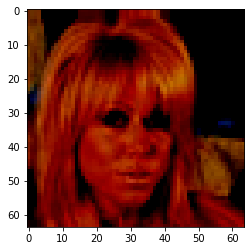

In [3]:
for data, target in dl:
    data, target = data[0].numpy().transpose(1, 2, 0), target[0]
    display(plt.imshow(data))
    print(f'Label: {target}')
    break

In [4]:
def init_weights(cls):
    cls_name = cls.__class__.__name__

    # init weights for conv tensors
    if cls_name.find('Conv') != -1:
        cls.weight.data.normal_(0.0, 0.02)

    # init weights for batch normalization tensors
    elif cls_name.find('BatchNorm') != -1:
        cls.weight.data.normal_(1.0, 0.02)
        cls.bias.data.fill_(0)


In [7]:
# create Generator instance and move to cuda
gen = Generator().cuda()
# create Discriminator instance and move to cuda
dis = Discriminator().cuda()

# apply init_weights() to all layers
gen.apply(init_weights)
dis.apply(init_weights)

# print summaries
print('-'*5 + 'Generator' + '-'*5)
display(summary(gen, input_size=(100, 1, 1)))
print('\n' + '-'*5 + 'Discriminator' + '-'*5)
display(summary(dis, input_size=(3, 100, 100)))

-----Generator-----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-1

None


-----Discriminator-----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           3,072
         LeakyReLU-2           [-1, 64, 50, 50]               0
            Conv2d-3          [-1, 128, 25, 25]         131,072
       BatchNorm2d-4          [-1, 128, 25, 25]             256
         LeakyReLU-5          [-1, 128, 25, 25]               0
            Conv2d-6          [-1, 256, 12, 12]         524,288
       BatchNorm2d-7          [-1, 256, 12, 12]             512
         LeakyReLU-8          [-1, 256, 12, 12]               0
            Conv2d-9            [-1, 512, 6, 6]       2,097,152
      BatchNorm2d-10            [-1, 512, 6, 6]           1,024
        LeakyReLU-11            [-1, 512, 6, 6]               0
           Conv2d-12              [-1, 1, 3, 3]           8,192
          Sigmoid-13              [-1, 1, 3, 3]               0
Total params: 

None

In [8]:
criterion = nn.BCELoss()
d_opt = optim.Adam(dis.parameters(), lr=LR, betas=(0.88, 0.99))
g_opt = optim.Adam(gen.parameters(), lr=LR, betas=(0.88, 0.99))

In [9]:
sample_noise = torch.randn(BATCH_SZ, GEN_IN, 1, 1).cuda()
print(sample_noise.shape)

torch.Size([64, 100, 1, 1])


In [13]:
history = {
'd_loss_real': [],
'd_loss_fake': [],
'd_acc': [],
'g_loss': [],
}

D_BEST_LOSS = float('inf')
G_BEST_LOSS = float('inf')

for epoch in range(EPOCHS):
    for idx, (data, target) in enumerate(dl):
        # move data and target to cuda
        data, target = data.cuda(), target.cuda()
        # create tensors for real and fake targets (1 / 0)
        data_real = data
        target_real = torch.full((data_real.size(0), ), REAL_TARGET).cuda()
        target_fake = torch.full((data_real.size(0), ), FAKE_TARGET).cuda()

        # Train discriminator on **REAL** data
        dis.zero_grad()
        pred_real = dis(data_real)
        d_loss_real = criterion(pred_real, target_real)
        d_loss_real.backward()

        # Train discriminator on **FAKE** data
        gen_noise = torch.randn(data_real.size(0), GEN_IN, 1, 1).cuda()
        data_fake = gen(gen_noise)
        pred_fake = dis(data_fake.detach())
        d_loss_fake = criterion(pred_fake, target_fake)
        d_loss_fake.backward()
        d_opt.step()

        # Train generator on fake data
        gen.zero_grad()
        gen_fake = dis(data_fake)
        g_loss = criterion(gen_fake, target_real)
        g_loss.backward()
        g_opt.step()

        # calculate mean losses
        d_loss_fake = d_loss_fake.mean().item()
        d_loss_real = d_loss_real.mean().item()
        g_loss = g_loss.mean().item()

        # Add loss to history
        history['d_loss_real'].append(d_loss_real)
        history['d_loss_fake'].append(d_loss_fake)
        history['g_loss'].append(g_loss)

        if idx % 100 == 0:

            # save progress images
            save_image(data_real, './progress_images/real_sample.png', normalize=True)
            with torch.no_grad():
                sample_img = gen(sample_noise)
                save_image(sample_img, f'./progress_images/gen_sample{epoch}.png', normalize=True)

            # print status updates
            print(f'\n-----Epoch: {epoch + 1}/{EPOCHS} Batch: {idx}/{BATCH_SZ}-----'
                  f'\nDiscriminator loss on real data: {d_loss_real:.4f}'
                  f'\nDiscriminator loss on fake data: {d_loss_fake:.4f}'
                  f'\nGenerator loss: {g_loss:.4f}')

        torch.save(dis.state_dict(), f'./models/discriminator{epoch}.pt')
        torch.save(gen.state_dict(), f'./models/generator{epoch}.pt')


-----Epoch: 1/75 Batch: 0/64-----
Discriminator loss on real data: 0.0706
Discriminator loss on fake data: 0.0012
Generator loss: 14.7949

-----Epoch: 1/75 Batch: 100/64-----
Discriminator loss on real data: 0.0918
Discriminator loss on fake data: 0.0011
Generator loss: 14.4305

-----Epoch: 1/75 Batch: 200/64-----
Discriminator loss on real data: 0.5367
Discriminator loss on fake data: 0.0049
Generator loss: 7.6830

-----Epoch: 1/75 Batch: 300/64-----
Discriminator loss on real data: 0.0268
Discriminator loss on fake data: 0.0006
Generator loss: 12.5989

-----Epoch: 1/75 Batch: 400/64-----
Discriminator loss on real data: 0.0205
Discriminator loss on fake data: 0.0318
Generator loss: 9.3101

-----Epoch: 1/75 Batch: 500/64-----
Discriminator loss on real data: 0.1205
Discriminator loss on fake data: 0.0278
Generator loss: 9.1847

-----Epoch: 1/75 Batch: 600/64-----
Discriminator loss on real data: 0.0448
Discriminator loss on fake data: 0.0361
Generator loss: 6.9902

-----Epoch: 1/75 B


-----Epoch: 2/75 Batch: 2700/64-----
Discriminator loss on real data: 0.0292
Discriminator loss on fake data: 0.0009
Generator loss: 15.9267

-----Epoch: 2/75 Batch: 2800/64-----
Discriminator loss on real data: 0.0524
Discriminator loss on fake data: 0.0329
Generator loss: 5.4861

-----Epoch: 2/75 Batch: 2900/64-----
Discriminator loss on real data: 0.2258
Discriminator loss on fake data: 0.0018
Generator loss: 8.6912

-----Epoch: 2/75 Batch: 3000/64-----
Discriminator loss on real data: 0.0013
Discriminator loss on fake data: 0.0835
Generator loss: 5.0714

-----Epoch: 2/75 Batch: 3100/64-----
Discriminator loss on real data: 0.0006
Discriminator loss on fake data: 0.0411
Generator loss: 7.1018

-----Epoch: 3/75 Batch: 0/64-----
Discriminator loss on real data: 0.0196
Discriminator loss on fake data: 0.2204
Generator loss: 5.9140

-----Epoch: 3/75 Batch: 100/64-----
Discriminator loss on real data: 0.0019
Discriminator loss on fake data: 0.2333
Generator loss: 7.2662

-----Epoch: 3/7


-----Epoch: 4/75 Batch: 2200/64-----
Discriminator loss on real data: 0.0517
Discriminator loss on fake data: 0.0526
Generator loss: 6.8658

-----Epoch: 4/75 Batch: 2300/64-----
Discriminator loss on real data: 0.0134
Discriminator loss on fake data: 0.2899
Generator loss: 6.0664

-----Epoch: 4/75 Batch: 2400/64-----
Discriminator loss on real data: 0.0204
Discriminator loss on fake data: 0.1596
Generator loss: 5.5475

-----Epoch: 4/75 Batch: 2500/64-----
Discriminator loss on real data: 0.0821
Discriminator loss on fake data: 0.0527
Generator loss: 6.9436

-----Epoch: 4/75 Batch: 2600/64-----
Discriminator loss on real data: 0.0020
Discriminator loss on fake data: 0.0244
Generator loss: 8.0530

-----Epoch: 4/75 Batch: 2700/64-----
Discriminator loss on real data: 0.1266
Discriminator loss on fake data: 0.0197
Generator loss: 6.9789

-----Epoch: 4/75 Batch: 2800/64-----
Discriminator loss on real data: 0.0234
Discriminator loss on fake data: 0.1374
Generator loss: 6.4590

-----Epoch: 


-----Epoch: 6/75 Batch: 1700/64-----
Discriminator loss on real data: 0.0044
Discriminator loss on fake data: 0.6120
Generator loss: 5.4960

-----Epoch: 6/75 Batch: 1800/64-----
Discriminator loss on real data: 0.0461
Discriminator loss on fake data: 0.0104
Generator loss: 9.8860

-----Epoch: 6/75 Batch: 1900/64-----
Discriminator loss on real data: 0.4883
Discriminator loss on fake data: 0.0971
Generator loss: 3.9285

-----Epoch: 6/75 Batch: 2000/64-----
Discriminator loss on real data: 0.5039
Discriminator loss on fake data: 0.2919
Generator loss: 2.8003

-----Epoch: 6/75 Batch: 2100/64-----
Discriminator loss on real data: 0.4704
Discriminator loss on fake data: 0.0798
Generator loss: 7.1080

-----Epoch: 6/75 Batch: 2200/64-----
Discriminator loss on real data: 0.0318
Discriminator loss on fake data: 0.0807
Generator loss: 5.9339

-----Epoch: 6/75 Batch: 2300/64-----
Discriminator loss on real data: 0.0179
Discriminator loss on fake data: 0.3511
Generator loss: 5.1464

-----Epoch: 


-----Epoch: 8/75 Batch: 1200/64-----
Discriminator loss on real data: 0.2049
Discriminator loss on fake data: 0.0068
Generator loss: 8.1395

-----Epoch: 8/75 Batch: 1300/64-----
Discriminator loss on real data: 0.0575
Discriminator loss on fake data: 0.0154
Generator loss: 5.4784

-----Epoch: 8/75 Batch: 1400/64-----
Discriminator loss on real data: 0.1018
Discriminator loss on fake data: 0.0618
Generator loss: 3.8231

-----Epoch: 8/75 Batch: 1500/64-----
Discriminator loss on real data: 0.0288
Discriminator loss on fake data: 0.0557
Generator loss: 2.4431

-----Epoch: 8/75 Batch: 1600/64-----
Discriminator loss on real data: 0.0626
Discriminator loss on fake data: 0.0553
Generator loss: 5.7421

-----Epoch: 8/75 Batch: 1700/64-----
Discriminator loss on real data: 0.0169
Discriminator loss on fake data: 0.0381
Generator loss: 5.4663

-----Epoch: 8/75 Batch: 1800/64-----
Discriminator loss on real data: 0.0004
Discriminator loss on fake data: 1.2229
Generator loss: 9.2128

-----Epoch: 


-----Epoch: 10/75 Batch: 700/64-----
Discriminator loss on real data: 0.0385
Discriminator loss on fake data: 0.0871
Generator loss: 5.6028

-----Epoch: 10/75 Batch: 800/64-----
Discriminator loss on real data: 0.0102
Discriminator loss on fake data: 0.0042
Generator loss: 8.8337

-----Epoch: 10/75 Batch: 900/64-----
Discriminator loss on real data: 0.1619
Discriminator loss on fake data: 0.0249
Generator loss: 4.7284

-----Epoch: 10/75 Batch: 1000/64-----
Discriminator loss on real data: 0.2961
Discriminator loss on fake data: 0.0015
Generator loss: 7.3515

-----Epoch: 10/75 Batch: 1100/64-----
Discriminator loss on real data: 0.4969
Discriminator loss on fake data: 0.0011
Generator loss: 6.1296

-----Epoch: 10/75 Batch: 1200/64-----
Discriminator loss on real data: 0.0333
Discriminator loss on fake data: 0.0743
Generator loss: 5.8125

-----Epoch: 10/75 Batch: 1300/64-----
Discriminator loss on real data: 0.0180
Discriminator loss on fake data: 0.0558
Generator loss: 7.2311

-----Epo


-----Epoch: 12/75 Batch: 100/64-----
Discriminator loss on real data: 0.9362
Discriminator loss on fake data: 0.0018
Generator loss: 4.4595

-----Epoch: 12/75 Batch: 200/64-----
Discriminator loss on real data: 0.6474
Discriminator loss on fake data: 0.0045
Generator loss: 6.9130

-----Epoch: 12/75 Batch: 300/64-----
Discriminator loss on real data: 0.0050
Discriminator loss on fake data: 0.1593
Generator loss: 5.0873

-----Epoch: 12/75 Batch: 400/64-----
Discriminator loss on real data: 0.3954
Discriminator loss on fake data: 0.0015
Generator loss: 7.9906

-----Epoch: 12/75 Batch: 500/64-----
Discriminator loss on real data: 0.0157
Discriminator loss on fake data: 0.0331
Generator loss: 4.8895

-----Epoch: 12/75 Batch: 600/64-----
Discriminator loss on real data: 0.2639
Discriminator loss on fake data: 0.0064
Generator loss: 8.3741

-----Epoch: 12/75 Batch: 700/64-----
Discriminator loss on real data: 0.0003
Discriminator loss on fake data: 0.1174
Generator loss: 4.3605

-----Epoch: 


-----Epoch: 13/75 Batch: 2700/64-----
Discriminator loss on real data: 0.0051
Discriminator loss on fake data: 0.1686
Generator loss: 5.5834

-----Epoch: 13/75 Batch: 2800/64-----
Discriminator loss on real data: 0.1387
Discriminator loss on fake data: 0.1825
Generator loss: 4.9562

-----Epoch: 13/75 Batch: 2900/64-----
Discriminator loss on real data: 0.0680
Discriminator loss on fake data: 0.0084
Generator loss: 6.9783

-----Epoch: 13/75 Batch: 3000/64-----
Discriminator loss on real data: 0.1287
Discriminator loss on fake data: 0.0114
Generator loss: 3.7446

-----Epoch: 13/75 Batch: 3100/64-----
Discriminator loss on real data: 0.0330
Discriminator loss on fake data: 0.0014
Generator loss: 8.1538

-----Epoch: 14/75 Batch: 0/64-----
Discriminator loss on real data: 0.0240
Discriminator loss on fake data: 0.0147
Generator loss: 6.2100

-----Epoch: 14/75 Batch: 100/64-----
Discriminator loss on real data: 0.4176
Discriminator loss on fake data: 0.0662
Generator loss: 6.7659

-----Epoc


-----Epoch: 15/75 Batch: 2100/64-----
Discriminator loss on real data: 0.0316
Discriminator loss on fake data: 0.0784
Generator loss: 4.2387

-----Epoch: 15/75 Batch: 2200/64-----
Discriminator loss on real data: 0.0001
Discriminator loss on fake data: 0.0267
Generator loss: 6.2401

-----Epoch: 15/75 Batch: 2300/64-----
Discriminator loss on real data: 0.0544
Discriminator loss on fake data: 0.0028
Generator loss: 8.8354

-----Epoch: 15/75 Batch: 2400/64-----
Discriminator loss on real data: 0.0631
Discriminator loss on fake data: 0.0106
Generator loss: 8.1718

-----Epoch: 15/75 Batch: 2500/64-----
Discriminator loss on real data: 0.0023
Discriminator loss on fake data: 0.0196
Generator loss: 6.1355

-----Epoch: 15/75 Batch: 2600/64-----
Discriminator loss on real data: 0.0192
Discriminator loss on fake data: 0.0055
Generator loss: 7.2520

-----Epoch: 15/75 Batch: 2700/64-----
Discriminator loss on real data: 0.0002
Discriminator loss on fake data: 0.3135
Generator loss: 4.9648

-----


-----Epoch: 17/75 Batch: 1500/64-----
Discriminator loss on real data: 0.2956
Discriminator loss on fake data: 0.0041
Generator loss: 6.9775

-----Epoch: 17/75 Batch: 1600/64-----
Discriminator loss on real data: 0.2954
Discriminator loss on fake data: 0.0024
Generator loss: 6.3605

-----Epoch: 17/75 Batch: 1700/64-----
Discriminator loss on real data: 0.0011
Discriminator loss on fake data: 0.0202
Generator loss: 7.4783

-----Epoch: 17/75 Batch: 1800/64-----
Discriminator loss on real data: 0.0518
Discriminator loss on fake data: 0.0238
Generator loss: 4.9078

-----Epoch: 17/75 Batch: 1900/64-----
Discriminator loss on real data: 0.0005
Discriminator loss on fake data: 0.0232
Generator loss: 6.2193

-----Epoch: 17/75 Batch: 2000/64-----
Discriminator loss on real data: 0.0000
Discriminator loss on fake data: 0.5204
Generator loss: 6.1288

-----Epoch: 17/75 Batch: 2100/64-----
Discriminator loss on real data: 0.0918
Discriminator loss on fake data: 0.0124
Generator loss: 6.3184

-----


-----Epoch: 19/75 Batch: 900/64-----
Discriminator loss on real data: 0.1964
Discriminator loss on fake data: 0.0081
Generator loss: 6.7486

-----Epoch: 19/75 Batch: 1000/64-----
Discriminator loss on real data: 0.0295
Discriminator loss on fake data: 0.0173
Generator loss: 7.8225

-----Epoch: 19/75 Batch: 1100/64-----
Discriminator loss on real data: 0.1497
Discriminator loss on fake data: 0.0079
Generator loss: 5.5481

-----Epoch: 19/75 Batch: 1200/64-----
Discriminator loss on real data: 0.0068
Discriminator loss on fake data: 0.0006
Generator loss: 8.7782

-----Epoch: 19/75 Batch: 1300/64-----
Discriminator loss on real data: 0.0105
Discriminator loss on fake data: 0.0125
Generator loss: 8.3764

-----Epoch: 19/75 Batch: 1400/64-----
Discriminator loss on real data: 0.0010
Discriminator loss on fake data: 0.0002
Generator loss: 9.3209

-----Epoch: 19/75 Batch: 1500/64-----
Discriminator loss on real data: 0.0008
Discriminator loss on fake data: 0.0089
Generator loss: 5.1732

-----E


-----Epoch: 21/75 Batch: 300/64-----
Discriminator loss on real data: 0.0052
Discriminator loss on fake data: 0.0205
Generator loss: 7.1252

-----Epoch: 21/75 Batch: 400/64-----
Discriminator loss on real data: 0.0715
Discriminator loss on fake data: 0.0008
Generator loss: 9.7991

-----Epoch: 21/75 Batch: 500/64-----
Discriminator loss on real data: 0.0002
Discriminator loss on fake data: 0.1557
Generator loss: 7.5760

-----Epoch: 21/75 Batch: 600/64-----
Discriminator loss on real data: 0.0755
Discriminator loss on fake data: 0.0024
Generator loss: 7.2682

-----Epoch: 21/75 Batch: 700/64-----
Discriminator loss on real data: 0.0085
Discriminator loss on fake data: 0.0812
Generator loss: 7.0708

-----Epoch: 21/75 Batch: 800/64-----
Discriminator loss on real data: 0.0063
Discriminator loss on fake data: 0.0031
Generator loss: 7.5492

-----Epoch: 21/75 Batch: 900/64-----
Discriminator loss on real data: 0.0001
Discriminator loss on fake data: 0.2393
Generator loss: 6.8037

-----Epoch: 


-----Epoch: 22/75 Batch: 2900/64-----
Discriminator loss on real data: 0.0108
Discriminator loss on fake data: 0.0041
Generator loss: 7.6029

-----Epoch: 22/75 Batch: 3000/64-----
Discriminator loss on real data: 0.0014
Discriminator loss on fake data: 0.0112
Generator loss: 5.6340

-----Epoch: 22/75 Batch: 3100/64-----
Discriminator loss on real data: 0.0273
Discriminator loss on fake data: 0.0004
Generator loss: 10.5868

-----Epoch: 23/75 Batch: 0/64-----
Discriminator loss on real data: 0.0623
Discriminator loss on fake data: 0.0004
Generator loss: 11.8405

-----Epoch: 23/75 Batch: 100/64-----
Discriminator loss on real data: 0.0234
Discriminator loss on fake data: 0.0010
Generator loss: 10.3980

-----Epoch: 23/75 Batch: 200/64-----
Discriminator loss on real data: 0.0000
Discriminator loss on fake data: 0.0140
Generator loss: 7.7974

-----Epoch: 23/75 Batch: 300/64-----
Discriminator loss on real data: 0.0027
Discriminator loss on fake data: 0.0028
Generator loss: 7.4334

-----Epo


-----Epoch: 24/75 Batch: 2300/64-----
Discriminator loss on real data: 0.0001
Discriminator loss on fake data: 0.1375
Generator loss: 5.7737

-----Epoch: 24/75 Batch: 2400/64-----
Discriminator loss on real data: 0.0004
Discriminator loss on fake data: 0.0303
Generator loss: 6.5631

-----Epoch: 24/75 Batch: 2500/64-----
Discriminator loss on real data: 0.0079
Discriminator loss on fake data: 0.0176
Generator loss: 7.9256

-----Epoch: 24/75 Batch: 2600/64-----
Discriminator loss on real data: 0.0010
Discriminator loss on fake data: 0.0660
Generator loss: 6.6809

-----Epoch: 24/75 Batch: 2700/64-----
Discriminator loss on real data: 0.0002
Discriminator loss on fake data: 0.0247
Generator loss: 9.1846

-----Epoch: 24/75 Batch: 2800/64-----
Discriminator loss on real data: 0.0008
Discriminator loss on fake data: 0.0122
Generator loss: 6.8309

-----Epoch: 24/75 Batch: 2900/64-----
Discriminator loss on real data: 0.0436
Discriminator loss on fake data: 0.0020
Generator loss: 10.7792

----


-----Epoch: 26/75 Batch: 1700/64-----
Discriminator loss on real data: 0.0026
Discriminator loss on fake data: 0.1663
Generator loss: 7.0262

-----Epoch: 26/75 Batch: 1800/64-----
Discriminator loss on real data: 0.0018
Discriminator loss on fake data: 0.0049
Generator loss: 7.2406

-----Epoch: 26/75 Batch: 1900/64-----
Discriminator loss on real data: 0.0007
Discriminator loss on fake data: 0.0389
Generator loss: 6.9393

-----Epoch: 26/75 Batch: 2000/64-----
Discriminator loss on real data: 0.1718
Discriminator loss on fake data: 0.0085
Generator loss: 7.4035

-----Epoch: 26/75 Batch: 2100/64-----
Discriminator loss on real data: 0.2015
Discriminator loss on fake data: 0.0016
Generator loss: 6.1032

-----Epoch: 26/75 Batch: 2200/64-----
Discriminator loss on real data: 0.0011
Discriminator loss on fake data: 0.0005
Generator loss: 12.2238

-----Epoch: 26/75 Batch: 2300/64-----
Discriminator loss on real data: 0.0525
Discriminator loss on fake data: 0.0047
Generator loss: 8.4923

----


-----Epoch: 28/75 Batch: 1100/64-----
Discriminator loss on real data: 0.1672
Discriminator loss on fake data: 0.0070
Generator loss: 7.3242

-----Epoch: 28/75 Batch: 1200/64-----
Discriminator loss on real data: 0.0136
Discriminator loss on fake data: 0.0028
Generator loss: 8.6809

-----Epoch: 28/75 Batch: 1300/64-----
Discriminator loss on real data: 0.0020
Discriminator loss on fake data: 0.0403
Generator loss: 7.4091

-----Epoch: 28/75 Batch: 1400/64-----
Discriminator loss on real data: 0.0018
Discriminator loss on fake data: 0.0225
Generator loss: 6.9924

-----Epoch: 28/75 Batch: 1500/64-----
Discriminator loss on real data: 0.0010
Discriminator loss on fake data: 0.0005
Generator loss: 10.3401

-----Epoch: 28/75 Batch: 1600/64-----
Discriminator loss on real data: 0.0001
Discriminator loss on fake data: 0.0411
Generator loss: 7.3460

-----Epoch: 28/75 Batch: 1700/64-----
Discriminator loss on real data: 0.0016
Discriminator loss on fake data: 0.0216
Generator loss: 8.3997

----


-----Epoch: 30/75 Batch: 500/64-----
Discriminator loss on real data: 0.0043
Discriminator loss on fake data: 0.0183
Generator loss: 7.1342

-----Epoch: 30/75 Batch: 600/64-----
Discriminator loss on real data: 0.1442
Discriminator loss on fake data: 0.0028
Generator loss: 6.6042

-----Epoch: 30/75 Batch: 700/64-----
Discriminator loss on real data: 0.0001
Discriminator loss on fake data: 1.1992
Generator loss: 5.5539

-----Epoch: 30/75 Batch: 800/64-----
Discriminator loss on real data: 0.0044
Discriminator loss on fake data: 0.0325
Generator loss: 7.8922

-----Epoch: 30/75 Batch: 900/64-----
Discriminator loss on real data: 0.0036
Discriminator loss on fake data: 0.0212
Generator loss: 7.1051

-----Epoch: 30/75 Batch: 1000/64-----
Discriminator loss on real data: 0.0137
Discriminator loss on fake data: 0.0017
Generator loss: 7.7718

-----Epoch: 30/75 Batch: 1100/64-----
Discriminator loss on real data: 0.0000
Discriminator loss on fake data: 0.0952
Generator loss: 5.2765

-----Epoch


-----Epoch: 31/75 Batch: 3100/64-----
Discriminator loss on real data: 0.0000
Discriminator loss on fake data: 0.0111
Generator loss: 7.4515

-----Epoch: 32/75 Batch: 0/64-----
Discriminator loss on real data: 0.0040
Discriminator loss on fake data: 0.0445
Generator loss: 5.9193

-----Epoch: 32/75 Batch: 100/64-----
Discriminator loss on real data: 0.0141
Discriminator loss on fake data: 0.0011
Generator loss: 13.3742

-----Epoch: 32/75 Batch: 200/64-----
Discriminator loss on real data: 0.0202
Discriminator loss on fake data: 0.0052
Generator loss: 6.0832

-----Epoch: 32/75 Batch: 300/64-----
Discriminator loss on real data: 0.0107
Discriminator loss on fake data: 0.0003
Generator loss: 12.9910

-----Epoch: 32/75 Batch: 400/64-----
Discriminator loss on real data: 0.0154
Discriminator loss on fake data: 0.0027
Generator loss: 9.1989

-----Epoch: 32/75 Batch: 500/64-----
Discriminator loss on real data: 0.0904
Discriminator loss on fake data: 0.0005
Generator loss: 11.0357

-----Epoch


-----Epoch: 33/75 Batch: 2500/64-----
Discriminator loss on real data: 0.8176
Discriminator loss on fake data: 0.0016
Generator loss: 2.7575

-----Epoch: 33/75 Batch: 2600/64-----
Discriminator loss on real data: 0.0153
Discriminator loss on fake data: 0.0061
Generator loss: 6.5188

-----Epoch: 33/75 Batch: 2700/64-----
Discriminator loss on real data: 0.0001
Discriminator loss on fake data: 0.0022
Generator loss: 8.8331

-----Epoch: 33/75 Batch: 2800/64-----
Discriminator loss on real data: 0.0012
Discriminator loss on fake data: 0.0089
Generator loss: 6.3721

-----Epoch: 33/75 Batch: 2900/64-----
Discriminator loss on real data: 0.0004
Discriminator loss on fake data: 0.1300
Generator loss: 7.2623

-----Epoch: 33/75 Batch: 3000/64-----
Discriminator loss on real data: 0.0025
Discriminator loss on fake data: 0.0080
Generator loss: 6.5468

-----Epoch: 33/75 Batch: 3100/64-----
Discriminator loss on real data: 0.0066
Discriminator loss on fake data: 0.0300
Generator loss: 5.8383

-----


-----Epoch: 35/75 Batch: 1900/64-----
Discriminator loss on real data: 0.1137
Discriminator loss on fake data: 0.0021
Generator loss: 6.7059

-----Epoch: 35/75 Batch: 2000/64-----
Discriminator loss on real data: 0.0004
Discriminator loss on fake data: 0.0129
Generator loss: 6.3610

-----Epoch: 35/75 Batch: 2100/64-----
Discriminator loss on real data: 0.3042
Discriminator loss on fake data: 0.0000
Generator loss: 12.3663

-----Epoch: 35/75 Batch: 2200/64-----
Discriminator loss on real data: 0.0213
Discriminator loss on fake data: 0.0273
Generator loss: 8.6095

-----Epoch: 35/75 Batch: 2300/64-----
Discriminator loss on real data: 0.0772
Discriminator loss on fake data: 0.0602
Generator loss: 6.6539

-----Epoch: 35/75 Batch: 2400/64-----
Discriminator loss on real data: 0.0048
Discriminator loss on fake data: 0.0015
Generator loss: 9.0214

-----Epoch: 35/75 Batch: 2500/64-----
Discriminator loss on real data: 1.4251
Discriminator loss on fake data: 0.0001
Generator loss: 12.1835

---

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Magic: 


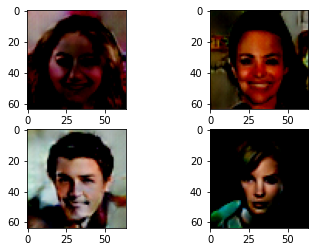

In [22]:
noise = torch.randn(4, GEN_IN, 1, 1).cuda()
out = gen(noise).cpu().detach().numpy()

print('Magic: ')

for idx, T in enumerate(out):
    plt.subplot(2, 2, idx+1)
    plt.imshow(T.transpose(1, 2, 0))
    
# oop

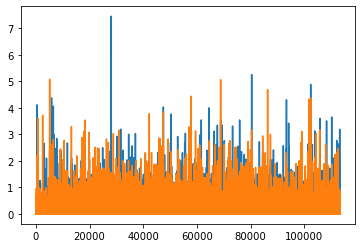

In [43]:
x = [i for i in range(len(history['d_loss_real']))]

display(plt.plot(x, history['d_loss_real']))
display(plt.plot(x, history['d_loss_fake']))

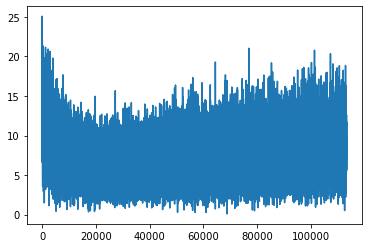

In [44]:
display(plt.plot(x, history['g_loss']))